In [51]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow import keras
import sys
import PIL
import os
import tensorflow.keras.backend as K
import glob
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [3]:
allowed_gpus = [7]
gpus = tf.config.list_physical_devices("GPU")
final_gpu_list = [gpus[x] for x in allowed_gpus]
tf.config.set_visible_devices(final_gpu_list, "GPU")

strategy = tf.distribute.MirroredStrategy()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [4]:
print(REPLICAS)

1


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [6]:
image_files = glob.glob('../files/train/*.jpg')

In [7]:
labels = []
for x in image_files:
    # dog == 1
    # cat == 0
    if 'dog' in x:
        labels.append(1)
    else:
        labels.append(0)

In [9]:
def read_img(im):
    img = tf.io.read_file(im)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (256, 256))
    img = img / 255
    return img

In [14]:
def get_dataset(image_list, batch_size = 32):
    tensor = tf.data.Dataset.from_tensor_slices(image_list)
    tensor = tensor.cache()
    tensor = tensor.map(read_img, num_parallel_calls=AUTO)
    tensor = tensor.batch(REPLICAS * batch_size)
    tensor = tensor.prefetch(AUTO)
    return tensor

In [16]:
tensor_data = get_dataset(image_files)

In [19]:
MyModel = tf.keras.models.Sequential()
MyModel.add(tf.keras.applications.ResNet50(
    include_top = False, weights='imagenet',    pooling='avg',
))

In [20]:
MyModel.layers[0].trainable = False

In [45]:
preds_ = MyModel.predict(tensor_data, verbose = 1)

782/782 [==============================] - 13s 16ms/step


In [30]:
from sklearn.cluster import AgglomerativeClustering

In [31]:
kmeans = AgglomerativeClustering(n_clusters = 2)

In [32]:
kmeans.fit(preds)

AgglomerativeClustering()

In [37]:
labels_numpy = np.array(labels)
preds = kmeans.labels_

In [43]:
TP = sum(np.logical_and(labels_numpy == 1, preds == 1))
TN = sum(np.logical_and(labels_numpy == 0, preds == 0))

In [47]:
dimReducedDataFrame = pd.DataFrame(preds_)
dimReducedDataFrame = dimReducedDataFrame.rename(columns = { 0: 'V1', 1 : 'V2'})

In [48]:
dimReducedDataFrame['Category'] = labels

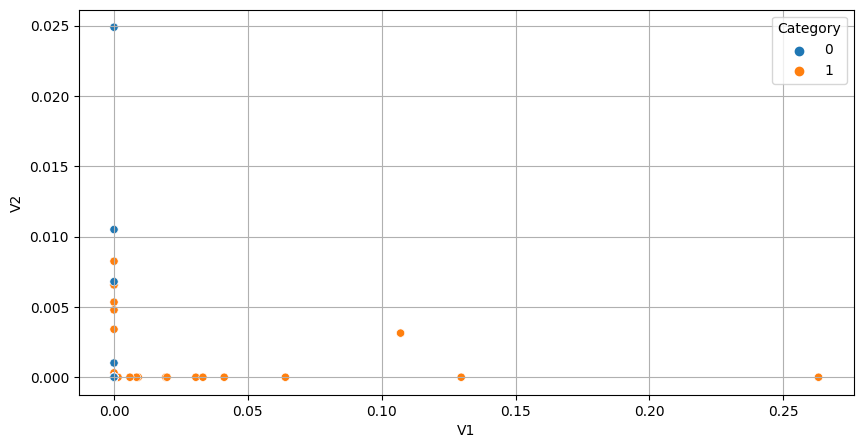

In [54]:
plt.figure(figsize = (10, 5))
sns.scatterplot(data = dimReducedDataFrame, x = 'V1', y = 'V2',hue = 'Category')
plt.grid(True)